<a href="https://colab.research.google.com/github/nimendra-ag/airline_sentiment_analysis_rnn/blob/main/Airline_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install opendatasets

In [9]:
import re
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import opendatasets as od
from tensorflow.keras import layers, regularizers

warnings.filterwarnings("ignore", category=FutureWarning)

In [10]:
od.download("https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nimendraamiththa
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment


100%|██████████| 2.55M/2.55M [00:00<00:00, 55.4MB/s]

In [11]:
data = pd.read_csv("twitter-airline-sentiment/Tweets.csv")
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [12]:
data[(data['airline_sentiment'] == 'positive') | (data['airline_sentiment'] == 'negative')]['text']

,text
1,@VirginAmerica plus you've added commercials t...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...
5,@VirginAmerica seriously would pay $30 a fligh...
6,"@VirginAmerica yes, nearly every time I fly VX..."
...,...
14633,@AmericanAir my flight was Cancelled Flightled...
14634,@AmericanAir right on cue with the delays👌
14635,@AmericanAir thank you we got on a different f...
14636,@AmericanAir leaving over 20 minutes Late Flig...


In [13]:
df = data[["text","airline_sentiment"]]
df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))

<ipython-input-13-0ce3478a8118>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))


In [14]:
df['text']

,text
0,What @dhepburn said.
1,plus you've added commercials to the experien...
2,I didn't today... Must mean I need to take an...
3,"it's really aggressive to blast obnoxious ""en..."
4,and it's a really big bad thing about it
...,...
14635,thank you we got on a different flight to Chi...
14636,leaving over 20 minutes Late Flight. No warni...
14637,Please bring American Airlines to #BlackBerry10
14638,"you have my money, you change my flight, and ..."


In [15]:
df

,text,airline_sentiment
0,What @dhepburn said.,neutral
1,plus you've added commercials to the experien...,positive
2,I didn't today... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative
...,...,...
14635,thank you we got on a different flight to Chi...,positive
14636,leaving over 20 minutes Late Flight. No warni...,negative
14637,Please bring American Airlines to #BlackBerry10,neutral
14638,"you have my money, you change my flight, and ...",negative


<Axes: xlabel='count', ylabel='airline'>

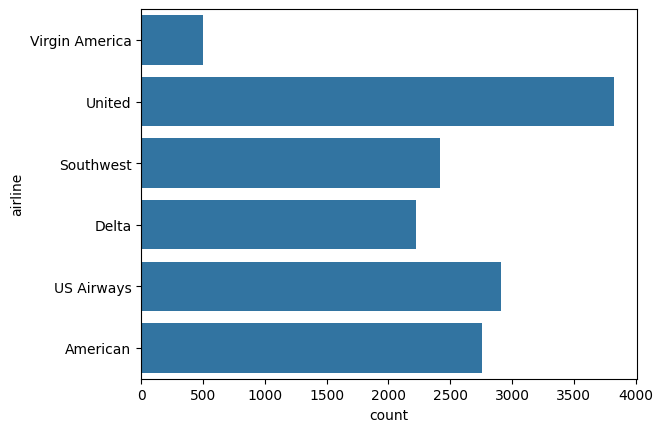

In [16]:
sns.countplot(data.airline)

In [17]:
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

<ipython-input-17-52a0c7d47819>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: x.lower())
<ipython-input-17-52a0c7d47819>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


In [18]:
df.head(5)

,text,airline_sentiment
0,what dhepburn said,neutral
1,plus youve added commercials to the experienc...,positive
2,i didnt today must mean i need to take anothe...,neutral
3,its really aggressive to blast obnoxious ente...,negative
4,and its a really big bad thing about it,negative


<Axes: xlabel='count', ylabel='airline_sentiment'>

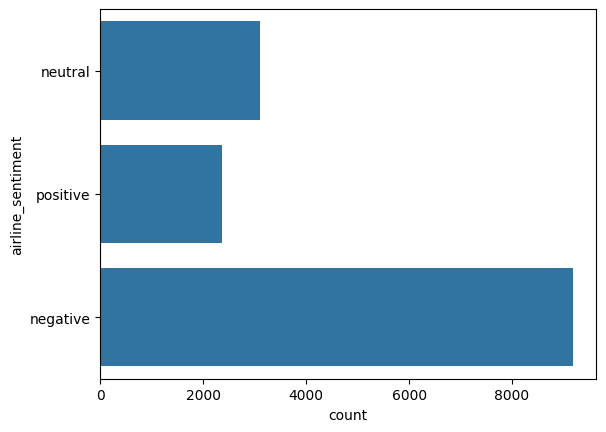

In [19]:
sns.countplot(df.airline_sentiment)

In [20]:
max_features = 4000
tokenizer = Tokenizer(num_words = max_features, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)

labels = df['airline_sentiment'].values

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, labels)

In [22]:
nl = 0
p = 0
n = 0
for x in y_resampled:
  if x  == 'positive':
    p += 1
  elif x == 'neutral':
    nl += 1
  else:
    n += 1
print(p, n, nl)

9178 9178 9178


<Axes: xlabel='count'>

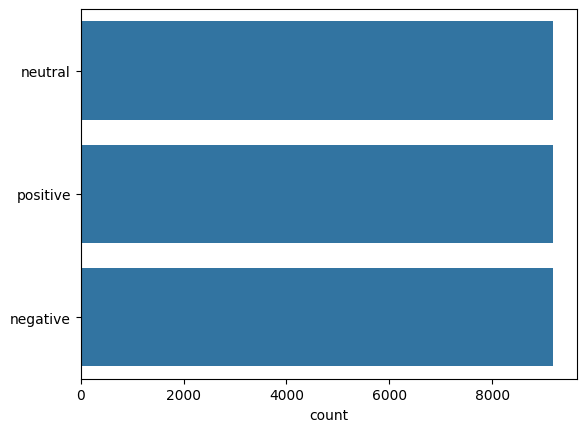

In [23]:
sns.countplot(pd.Series(y_resampled))

In [24]:
k = []
for i, target in enumerate(y_resampled):
  if target == 'positive':
    k.append(1)
  else:
    k.append(0)

k = np.array(k)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, k, test_size=0.3)

# Defining the model

In [26]:
# embed_dim = 128
# lstm_out = 196
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Embedding(max_features, 128, input_length = X_train.shape[1]))
# model.add(tf.keras.layers.LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.3))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.4))
# model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

In [27]:
# Define model parameters
embed_dim = 128       # Embedding dimension
lstm_out = 256        # Increased LSTM units

model = tf.keras.models.Sequential()

# Add pretrained embedding layer with slight dropout
model.add(layers.Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(layers.SpatialDropout1D(0.2))  # Helps regularize embedding layer

# Layer Normalization before LSTM (Improves stability)
model.add(layers.LayerNormalization())

# Add Bidirectional LSTM with L2 regularization
model.add(layers.Bidirectional(layers.LSTM(
    lstm_out,
    dropout=0.15, recurrent_dropout=0.2,
    kernel_regularizer=regularizers.l2(0.001),
    return_sequences=True
)))

# Add another smaller LSTM layer
model.add(layers.LSTM(
    64, dropout=0.15, recurrent_dropout=0.15,
    kernel_regularizer=regularizers.l2(0.001)
))

# Add Batch Normalization
model.add(layers.BatchNormalization())

# Add Fully Connected Layers with L2 regularization
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))  # Slightly lower dropout for better balance

# Output layer for multi-class classification
model.add(layers.Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ ?                           │     0 (unbuilt) │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Training the model

In [31]:
history = model.fit(X_train,
                         Y_train,
                         epochs=20,
                         batch_size=32,
                         validation_split = 0.2,
                         verbose = 2,
                         callbacks=[es_callback]
                    )

Epoch 1/20
482/482 - 334s - 694ms/step - accuracy: 0.6743 - loss: 1.1302 - val_accuracy: 0.7136 - val_loss: 0.8168
Epoch 2/20
482/482 - 319s - 661ms/step - accuracy: 0.7536 - loss: 0.7039 - val_accuracy: 0.7237 - val_loss: 0.6822
Epoch 3/20
482/482 - 309s - 641ms/step - accuracy: 0.7949 - loss: 0.5576 - val_accuracy: 0.7261 - val_loss: 0.6768
Epoch 4/20
482/482 - 315s - 653ms/step - accuracy: 0.8249 - loss: 0.4738 - val_accuracy: 0.7211 - val_loss: 0.6528
Epoch 5/20
482/482 - 312s - 648ms/step - accuracy: 0.8484 - loss: 0.4237 - val_accuracy: 0.7082 - val_loss: 0.7227
Epoch 6/20
482/482 - 304s - 630ms/step - accuracy: 0.8718 - loss: 0.3770 - val_accuracy: 0.7108 - val_loss: 0.8231
Epoch 7/20
482/482 - 322s - 668ms/step - accuracy: 0.8909 - loss: 0.3388 - val_accuracy: 0.7222 - val_loss: 0.9200


In [32]:
score = model.evaluate(X_test, Y_test, verbose=False)
# print("loss", score[0])
# print("accuracy", score[1])
print(score)

[0.6443528532981873, 0.7214623093605042]


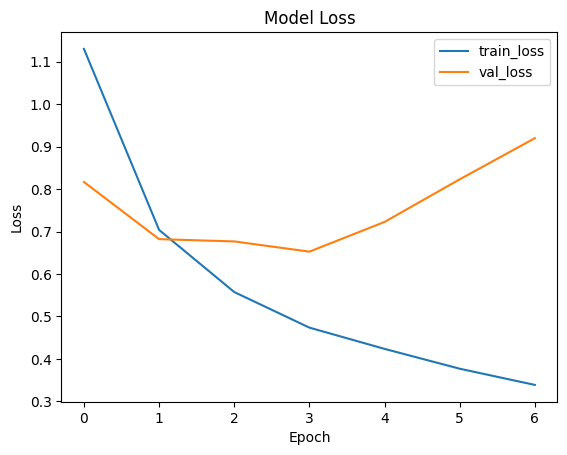

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

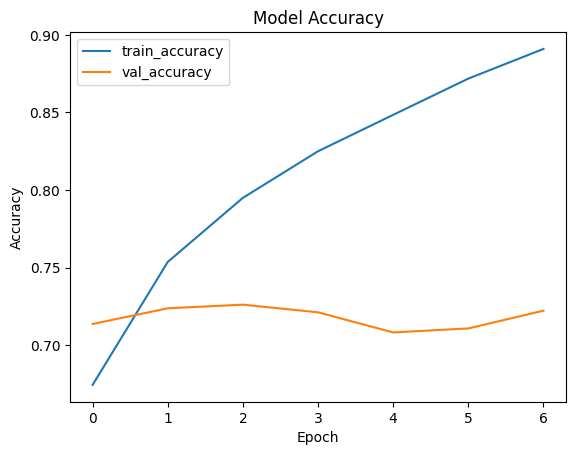

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])

259/259 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step


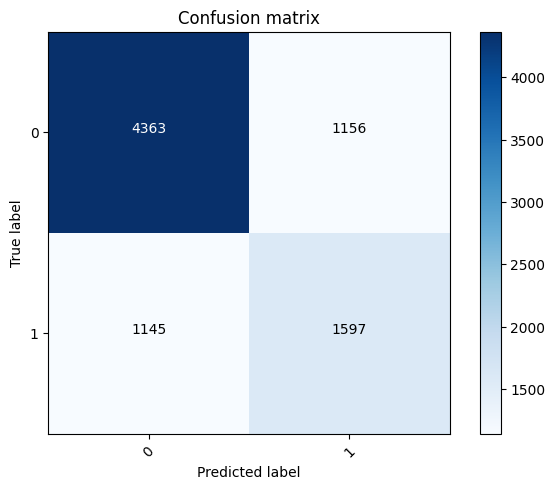

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
confusion_mtx = confusion_matrix(Y_test, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [39]:
sample = ["a good experience"]
sample = tokenizer.texts_to_sequences(sample)
sample = pad_sequences(sample, maxlen=31, dtype='int32', value=0)
print(sample)
sentiment = model.predict(sample,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   4 129 194]]
1/1 - 0s - 100ms/step
positive
